# 1. Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from IPython.display import display
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from pathlib import Path

# 2. Load data 

In [2]:
train_df = pd.read_csv('./data/train.csv').drop(columns=['id'])
test_df = pd.read_csv('./data/test.csv')
FEATURES = train_df.columns[:-1]
TARGET = train_df.columns[-1]
print(train_df.shape)
print(test_df.shape)

(42100, 18)
(28068, 18)


# 3. EDA

In [3]:
# Describe dataset
train_df[FEATURES].describe().T.sort_values(by='std', ascending=False)\
    .style.background_gradient(cmap='GnBu')

,count,mean,std,min,25%,50%,75%,max
lead_time,42100.000000,103.888029,81.069343,0.000000,37.000000,93.000000,155.000000,443.000000
avg_price_per_room,42100.000000,104.566377,37.139165,0.000000,80.000000,99.450000,123.300000,540.000000
arrival_date,42100.000000,15.902945,8.888582,1.000000,8.000000,16.000000,24.000000,31.000000
arrival_month,42100.000000,7.593539,2.829395,1.000000,6.000000,8.000000,10.000000,12.000000
no_of_previous_bookings_not_canceled,42100.000000,0.175772,1.732121,0.000000,0.000000,0.000000,0.000000,58.000000
no_of_week_nights,42100.000000,2.398005,1.427330,0.000000,1.000000,2.000000,3.000000,17.000000
no_of_weekend_nights,42100.000000,0.884632,0.885693,0.000000,0.000000,1.000000,2.000000,7.000000
room_type_reserved,42100.000000,0.428931,0.832605,0.000000,0.000000,0.000000,1.000000,6.000000
no_of_special_requests,42100.000000,0.571734,0.775041,0.000000,0.000000,0.000000,1.000000,5.000000
market_segment_type,42100.000000,0.728504,0.633529,0.000000,0.000000,1.000000,1.000000,4.000000


In [4]:
# Check for nans in train set
train_df.isna().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

In [5]:
# Check for nans in test set
test_df.isna().sum()

id                                      0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
dtype: int64

In [6]:
# Check for duplicates in train data
train_df[[col for col in train_df.columns if col != 'booking_status']].duplicated().sum()

562

In [7]:
# These duplicates are ambiguous regarding the label? --> Pendiente
train_df[train_df[FEATURES].duplicated(keep='first')]

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
1870,1,0,0,2,2,0,0,377,2018,10,14,0,0,0,0,90.00,0,0
2477,2,0,2,0,0,0,0,275,2018,4,17,0,0,0,0,110.00,0,1
3685,2,0,1,2,0,0,0,224,2017,10,2,0,0,0,0,65.00,0,0
4025,2,0,0,5,0,0,0,230,2018,9,6,1,0,0,0,137.00,0,0
4070,2,0,0,4,0,0,1,213,2018,8,31,1,0,0,0,118.15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42045,2,0,2,3,0,0,0,118,2018,4,10,1,0,0,0,90.95,0,1
42050,2,0,0,2,0,0,0,322,2018,12,9,0,0,0,0,52.00,0,0
42071,2,0,0,2,2,0,0,257,2018,7,1,0,0,0,0,101.50,0,0
42077,2,0,0,1,0,0,0,131,2018,7,23,1,0,0,0,105.30,1,0


In [8]:
# Drop duplicates from the training dataset
train_df = train_df.loc[train_df[~train_df[FEATURES].duplicated(keep='first')].index.tolist()]
print(train_df.shape)

(41538, 18)


In [9]:
# Check the type of variables that dataset has

for col in train_df[FEATURES]: 
    print(train_df[col].value_counts())

2    30318
1     6988
3     4053
0      167
4       12
Name: no_of_adults, dtype: int64
0    37230
1     2724
2     1560
3       17
4        5
9        2
Name: no_of_children, dtype: int64
0    17857
2    12019
1    11233
3      237
4      128
5       46
6       17
7        1
Name: no_of_weekend_nights, dtype: int64
2     12698
3     10141
1      9413
4      4133
5      2569
0      1920
6       237
7       159
8        83
10       82
9        53
11       16
15       11
12        9
13        5
16        4
14        3
17        2
Name: no_of_week_nights, dtype: int64
0    35030
2     3313
1     3189
3        6
Name: type_of_meal_plan, dtype: int64
0    40476
1     1062
Name: required_car_parking_space, dtype: int64
0    29321
1     9111
3     1464
2     1128
4      318
5      190
6        6
Name: room_type_reserved, dtype: int64
1      842
0      826
2      502
6      497
3      480
      ... 
348      1
310      1
325      1
300      1
353      1
Name: lead_time, Length: 338, dtype: int

## 3.1. Categorical & Continuous variables

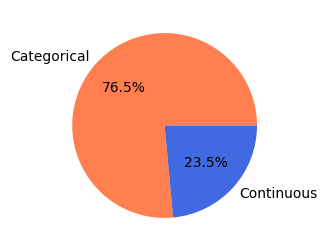

In [31]:
# Select categorical and continuous variables: 
# I will set categorical variables to the ones with less than 10 categories
categorical_features = []
continuous_features = []

for col in FEATURES: 
    if train_df[col].nunique() <=31: 
        categorical_features.append(col)
    else: 
        continuous_features.append(col) 


fig = plt.figure(figsize=(6,3))
plt.pie(
    [len(categorical_features), len(continuous_features)],
    labels = ['Categorical', 'Continuous'], 
    colors=['coral','royalblue'], 
    autopct='%1.1f%%'
)
plt.show()

In [12]:
len(continuous_features)

3

## 3.2. Visualize continuous variables

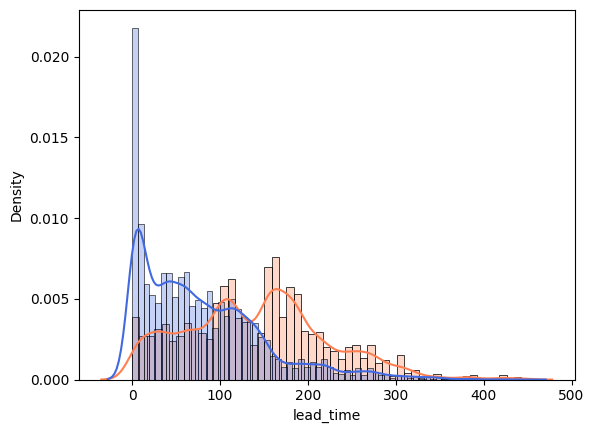

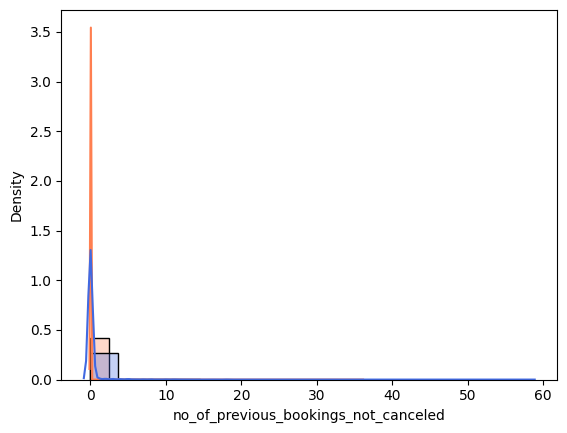

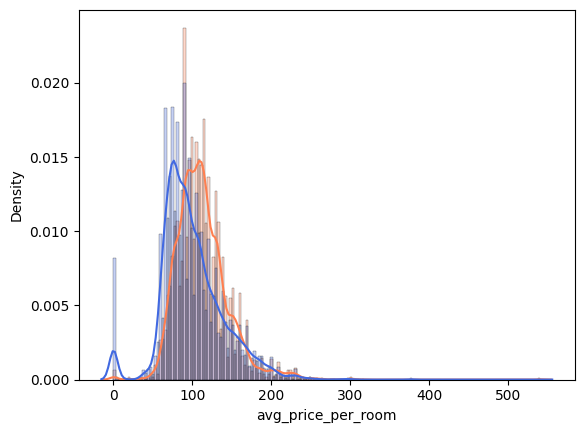

In [13]:
nrows = 3
ncols = 1
plt.figure()
for col in continuous_features: 
    sns.kdeplot(train_df[train_df[TARGET]==1][col], label=1, color='coral')
    sns.histplot(train_df[train_df[TARGET]==1][col], color='coral', alpha = 0.3, stat='density')
    sns.kdeplot(train_df[train_df[TARGET]==0][col], label = 0, color = 'royalblue')
    sns.histplot(train_df[train_df[TARGET]==0][col], color='royalblue', alpha = 0.3, stat='density')
    min_f = train_df[col].min()
    max_f = train_df[col].max()
    plt.show()
    

- Looking at the data we can see that lead_time > 150 tend to booking canceled = 1  while the others < 150 tend to 0.
- Avg_price_per_room > 100 tend to be cancelled more than kept. 
- In summer months: June, July, August, Sept and Oct there's a higher chance to cancel.

## 3.3. Visualize categorical data 

<Figure size 640x480 with 0 Axes>

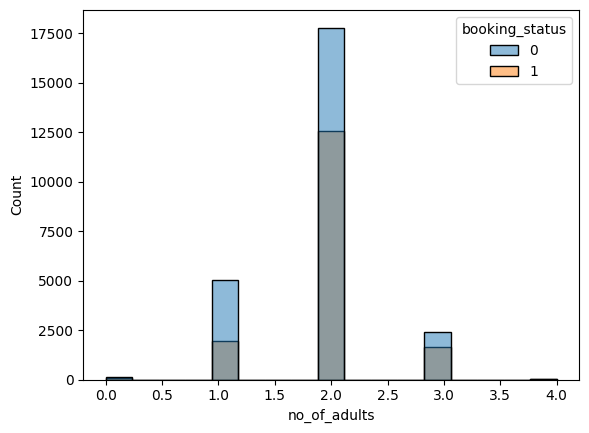

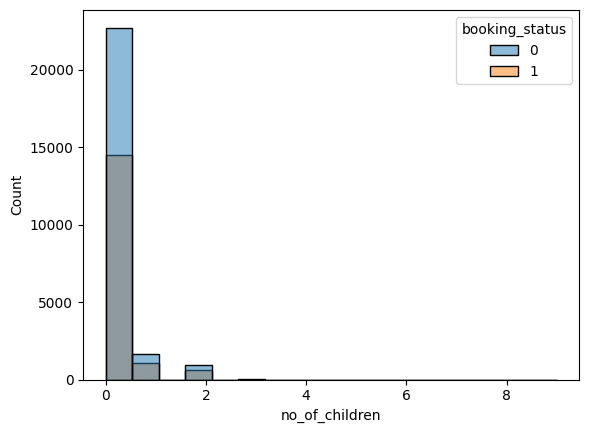

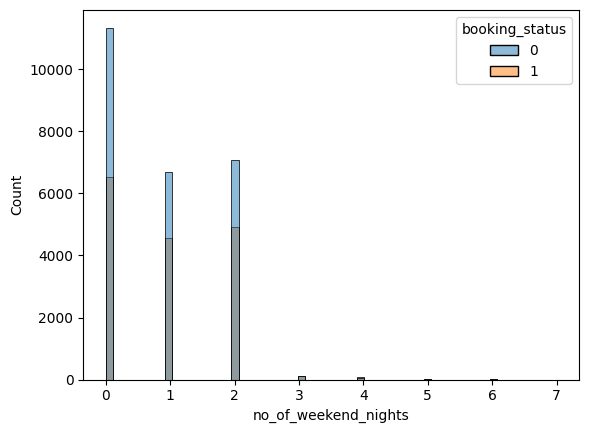

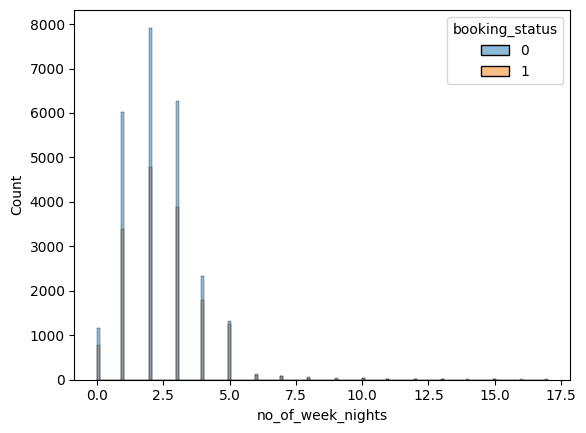

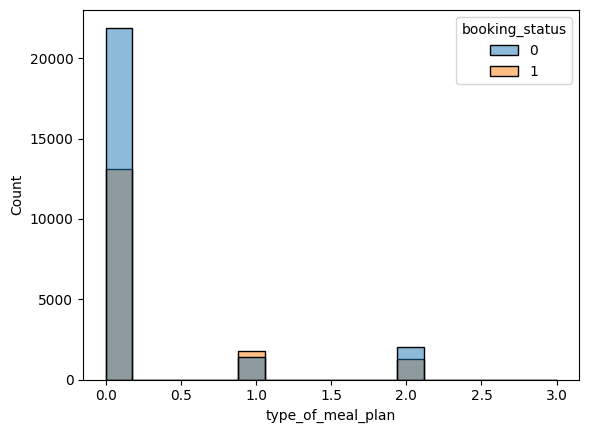

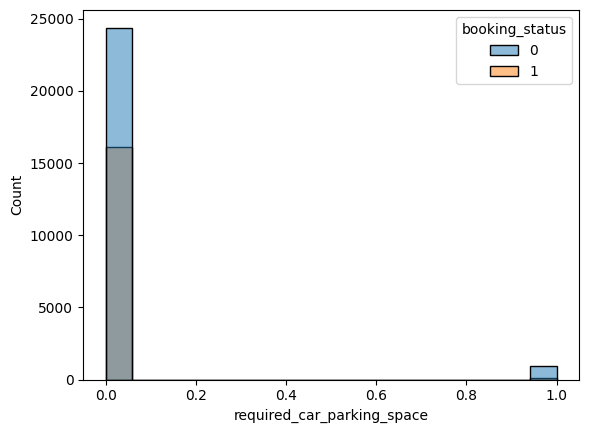

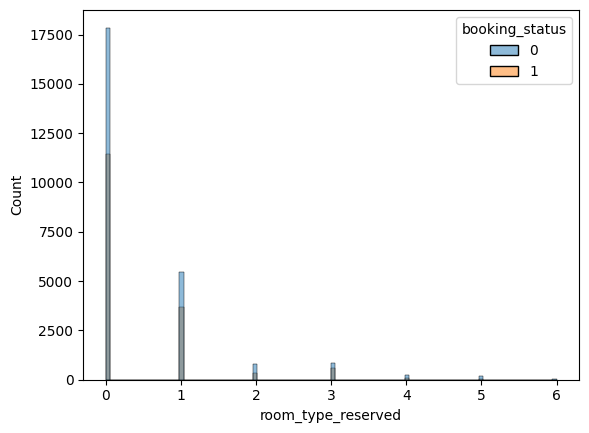

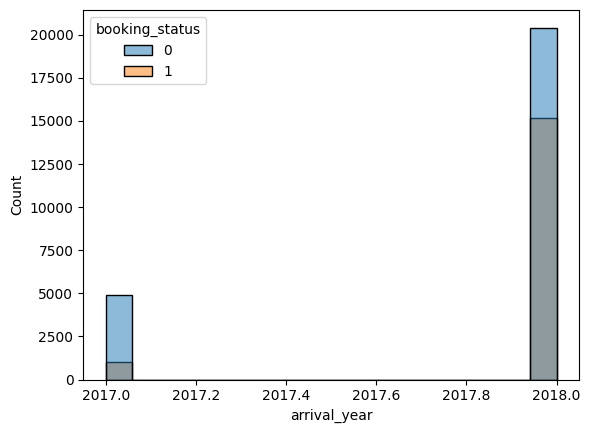

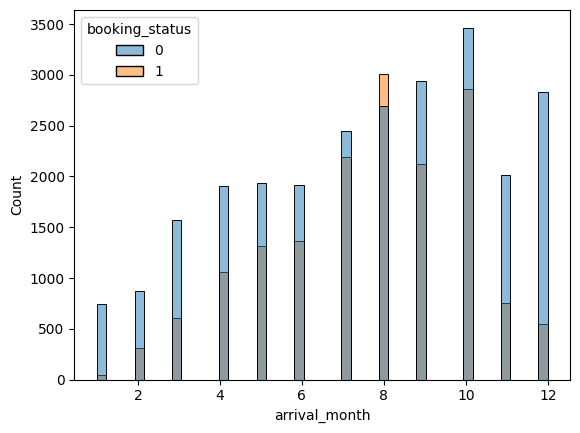

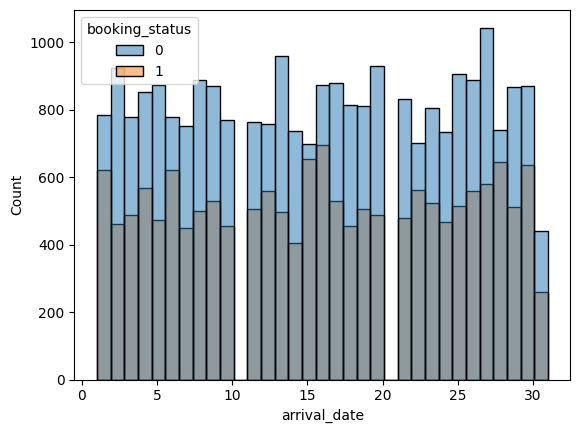

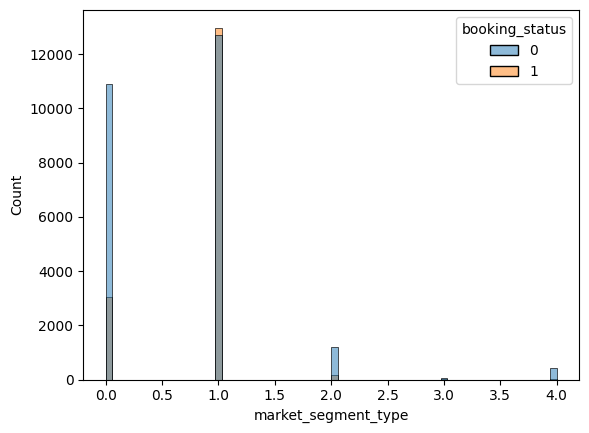

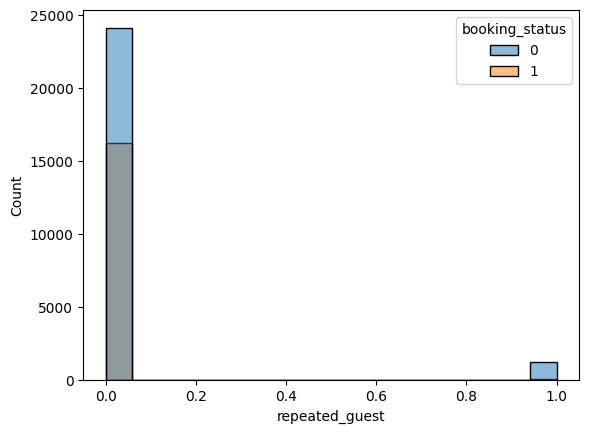

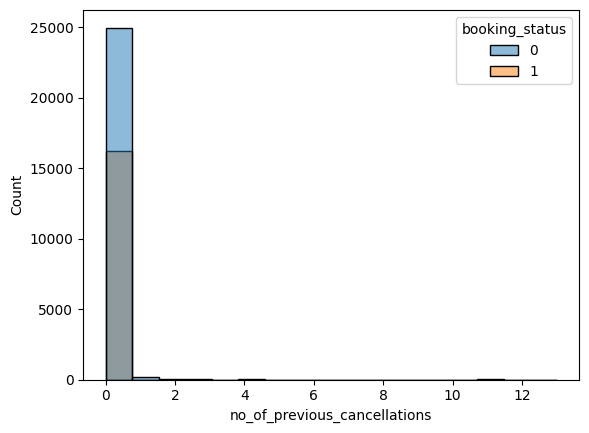

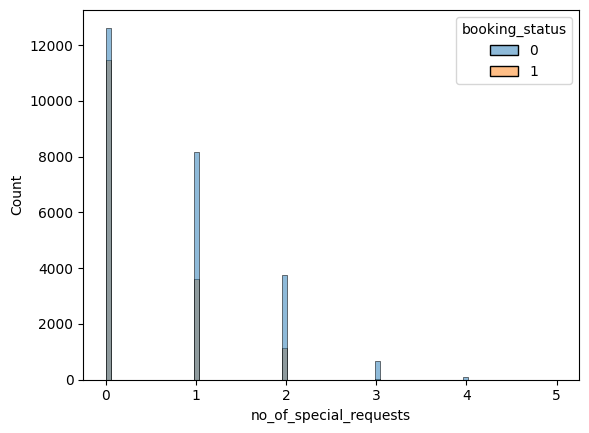

In [14]:
plt.subplots_adjust(hspace=0.8)
#fig, axes = plt.subplots(11, 1, figsize=(10,30))
plt.subplots_adjust(hspace=0.8)
i = 0

plt.figure()
for col in categorical_features: 
    sns.histplot(data = train_df , x = col, hue = TARGET)
    plt.show()

Looking at categorical data we can extract the following: 
- People without previous cancelations tend to not cancel a book 
- People with 1 or more special requests tend to not cancel a book. 
- Required parking space tend to not cancel a book 
- People without children tend to not cancel books
- 1-2 adults tend to not cancel books. 
- Plans that involve 0-3 weekend night tend to not being cancelled. 


## 3.4. TimeCycle

In [15]:
# 2017 and 2018 are not "año bisiesto". Replace arrival date > 28 by 28. 
train_df.loc[(train_df['arrival_month']==2) & (train_df['arrival_date']>28),'arrival_date'] = str(28)
train_df['arrival_year_month_date'] = pd.to_datetime(train_df['arrival_year'].astype(str)+'/'+train_df['arrival_month'].astype(str)+'/'+train_df['arrival_date'].astype(str), format="%Y/%m/%d",errors='coerce')

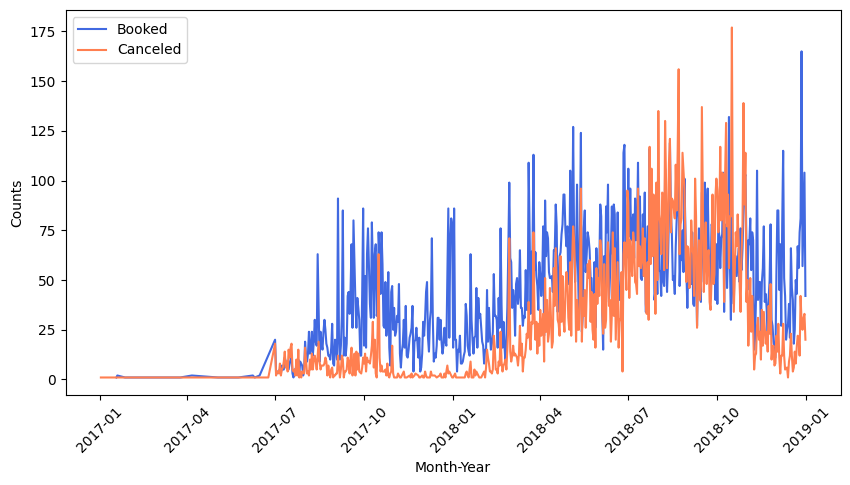

In [16]:
plt.figure(figsize=(10,5))
sns.lineplot(train_df[train_df[TARGET]==0]['arrival_year_month_date'].value_counts(), label = 'Booked', color='royalblue')
sns.lineplot(train_df[train_df[TARGET]==1]['arrival_year_month_date'].value_counts(), label = 'Canceled', color='coral')
plt.xlabel('Month-Year')
plt.ylabel('Counts')
plt.xticks(rotation = 45)
plt.legend()

In [17]:
# Group by week 
train_df['week'] = train_df['arrival_year_month_date'].dt.isocalendar().week.astype(float)

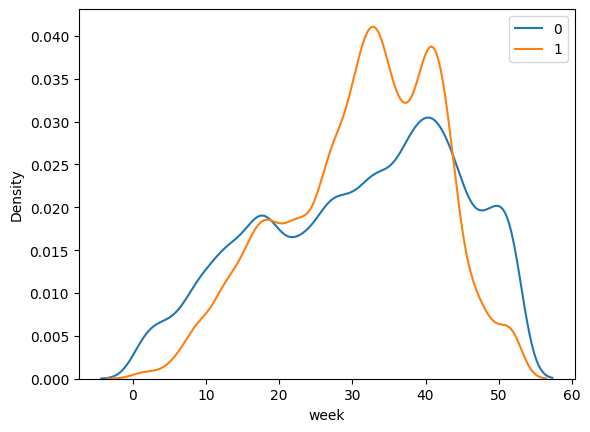

In [18]:
sns.kdeplot(train_df[train_df[TARGET]==0]['week'], label=0)
sns.kdeplot(train_df[train_df[TARGET]==1]['week'], label=1)
plt.legend()

## 3.5. Correlation matrix 

<AxesSubplot:>

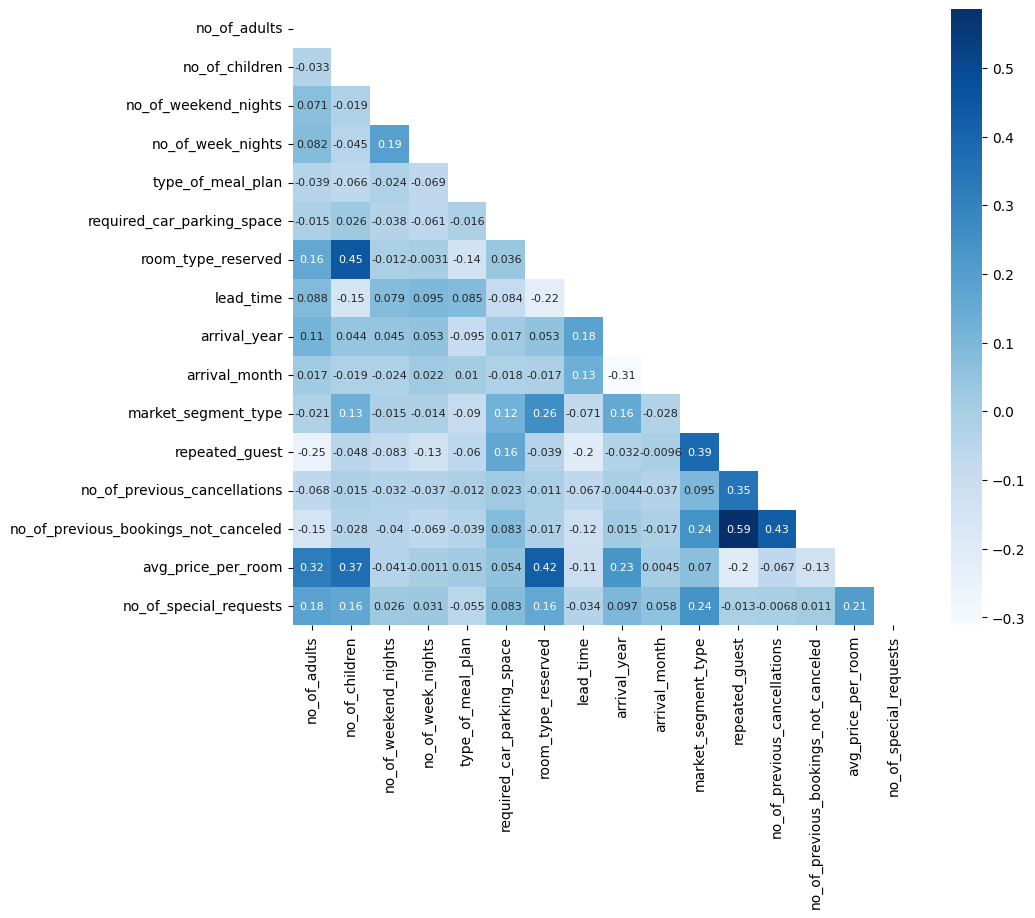

In [19]:
mask = np.zeros_like(train_df[FEATURES].corr(), dtype='bool')
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,8))
sns.heatmap(train_df[FEATURES].corr(), mask = mask, cmap= 'Blues', annot = True, annot_kws={"size":8}, )

# 4. Feature encoding

In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from category_encoders import LeaveOneOutEncoder

In [40]:
def preprocess_data(df): 
    # Group by week 
    df['arrival_year_month_date'] = pd.to_datetime(df['arrival_year'].astype(str)+'/'+df['arrival_month'].astype(str)+'/'+df['arrival_date'].astype(str), format="%Y/%m/%d",errors='coerce')
    df['week'] = df['arrival_year_month_date'].dt.isocalendar().week.astype(float)

    df['arrival_date'] = df['arrival_date'].astype(int)
    df['arrival_month'] = df['arrival_month'].astype(int)
    df['arrival_year'] = df['arrival_year'].astype(int)
    
    return(df)

test_df = preprocess_data(test_df)

In [34]:
print(train_df['week'].nunique())
categorical_features = categorical_features + ["week"]

52


In [41]:
train_df[categorical_features] = train_df[categorical_features].astype('category')
test_df[categorical_features] = test_df[categorical_features].astype('category')

In [42]:
# Encoding categorical features
loe = LeaveOneOutEncoder(sigma=0.05)
loe.fit(train_df[categorical_features], y=train_df[TARGET])
train_df[categorical_features] = loe.transform(train_df[categorical_features])
test_df [categorical_features] = loe.transform(test_df[categorical_features])

In [44]:
from sklearn.preprocessing import StandardScaler

In [45]:
# Normalize continuous data
numerical_features = ["lead_time", "avg_price_per_room"]
sc = StandardScaler()
sc.fit(train_df[numerical_features])
train_df[numerical_features] = sc.transform(train_df[numerical_features])
test_df[numerical_features] = sc.transform(test_df[numerical_features])


# 5. Model baseline 

In [46]:
FEATURES =  [col for col in train_df.columns if col != 'booking_status' and col!='arrival_year_month_date' and col!='no_of_previous_cancellations']
TARGET = 'booking_status'

In [47]:
train_df['arrival_date'] = train_df['arrival_date'].astype(int)
train_df['arrival_month'] = train_df['arrival_month'].astype(int)
train_df['arrival_year'] = train_df['arrival_year'].astype(int)

In [48]:
# Decision Trees and Random Forest do not require feature scaling. 
# I am going to try several models

skf = StratifiedKFold(n_splits = 5, shuffle = True)
lgb_scores = []
xgb_scores = []
fim_dfs = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df[FEATURES], train_df[TARGET])): 
    X_train, X_valid = train_df[FEATURES].iloc[train_idx], train_df[FEATURES].iloc[valid_idx]
    y_train, y_valid = train_df[TARGET].iloc[train_idx], train_df[TARGET].iloc[valid_idx]

    lgbm = LGBMClassifier(objective='binary', metric = 'auc', n_estimators=100)
    xgb = XGBClassifier(objective='binary:logistic', n_estimators = 100)

    lgbm.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    lgb_scores.append(roc_auc_score(y_valid, lgbm.predict_proba(X_valid)[:,1]))
    xgb_scores.append(roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:,1]))



    fim = pd.DataFrame(index = FEATURES, 
    data = {
        f'lgbm_{fold}_importance': lgbm.feature_importances_, 
        f'xgb_{fold}_importance': xgb.feature_importances_
        })

    fim_dfs.append(fim)    
print(f'Mean AUC LGBM: {np.array(lgb_scores).mean()}')
print(f'Mean AUC XGBoost {np.array(xgb_scores).mean()}')

Mean AUC LGBM: 0.8964354350072746
Mean AUC XGBoost 0.8984828199455043


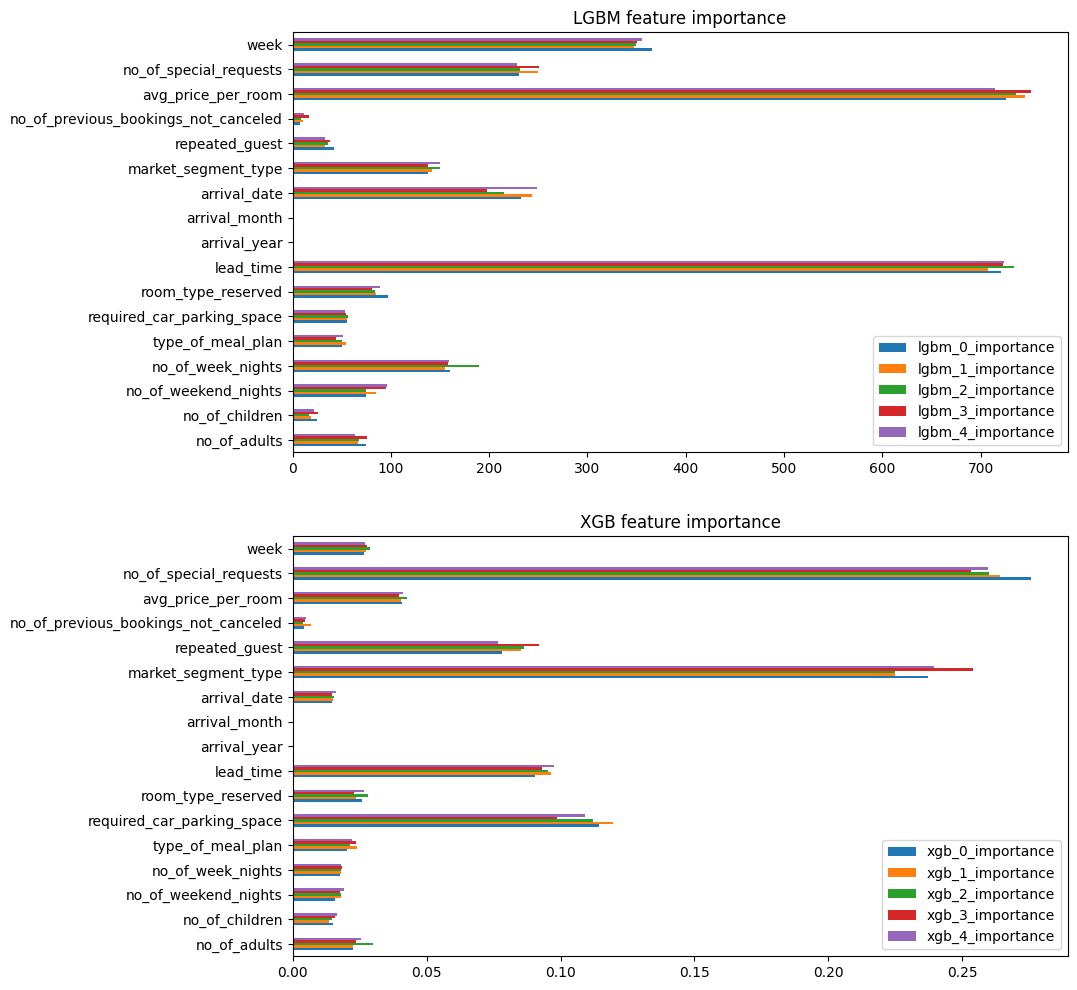

In [49]:
fig, axs = plt.subplots(2,1, figsize= (15,18))
fims = pd.concat(fim_dfs, axis=1)
axs[0] = fims[fims.columns[fims.columns.isin('lgbm_'+str(i)+'_importance' for i in range(0,5))]].plot(kind='barh', figsize=(10,12), title='LGBM feature importance', ax = axs[0])
axs[1] = fims[fims.columns[fims.columns.isin('xgb_'+str(i)+'_importance' for i in range(0,5))]].plot(kind='barh', figsize=(10,12), title='XGB feature importance', ax= axs[1])


# 6. Hyperparameter tunning

In [52]:
xgb_parameters2search = {
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "n_estimators": np.arange(25,150,25)}
xgb = XGBClassifier()
gv_clf = GridSearchCV(lgbm, xgb_parameters2search, scoring = 'roc_auc', cv=5)
gv_clf.fit(train_df[FEATURES], train_df[TARGET])
print(gv_clf.best_params_) 

{'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 125}


# 7. Model test predictions 


In [22]:
def preprocess_data(df): 
    # Group by week 
    df['arrival_year_month_date'] = pd.to_datetime(df['arrival_year'].astype(str)+'/'+df['arrival_month'].astype(str)+'/'+df['arrival_date'].astype(str), format="%Y/%m/%d",errors='coerce')
    df['week'] = df['arrival_year_month_date'].dt.isocalendar().week.astype(float)

    df['arrival_date'] = df['arrival_date'].astype(int)
    df['arrival_month'] = df['arrival_month'].astype(int)
    df['arrival_year'] = df['arrival_year'].astype(int)
    
    return(df)

test_df = preprocess_data(test_df)

In [23]:
xgb = XGBClassifier(objective='binary:logistic', n_estimators = 125, max_depth = 10, learning_rate=0.15)
xgb.fit(train_df[FEATURES], train_df[TARGET])
preds = xgb.predict(test_df[FEATURES])
pd.DataFrame({'id': pd.read_csv('./data/sample_submission.csv')['id'], 'booking_status' : preds}).to_csv('./data/results_2.csv', index=False)

In [24]:
pd.read_csv('./data/results_2.csv')

,id,booking_status
0,42100,0
1,42101,0
2,42102,0
3,42103,0
4,42104,1
...,...,...
28063,70163,1
28064,70164,0
28065,70165,0
28066,70166,0
